# Import Library

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load Final Data

In [3]:
df=pd.read_csv('./data/asos_selling.csv')
df

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday,avg_tem,max_tem,min_tem,max_rain,hr_max_rain,max_wind,avg_sun
0,BC_A_J_20190101,2019-01-01,BC,A,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
1,BC_B_J_20190101,2019-01-01,BC,B,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
2,BC_C_J_20190101,2019-01-01,BC,C,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
3,BC_D_J_20190101,2019-01-01,BC,D,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
4,BC_E_J_20190101,2019-01-01,BC,E,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_E_S_20230302,2023-03-02,RD,E,S,97.0,6.78,2023,3,9,3,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59393,RD_A_S_20230303,2023-03-03,RD,A,S,160.6,6.13,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59394,RD_C_S_20230303,2023-03-03,RD,C,S,0.0,0.00,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59395,RD_D_S_20230303,2023-03-03,RD,D,S,85.8,6.01,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157


# Preprocessing for Training

In [60]:
idx_list = []

for item in df['item'].unique():
    i_df = df[df['item'] == item]
    
    Q1 = i_df['price'].quantile(0.25)
    Q3 = i_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    
    idx_list.extend(i_df[i_df['price'] > upper_bound].index)

df.drop(idx_list, inplace=True)
df.reset_index(drop=True,inplace=True)

In [61]:
hol_d=['2019-01-02','2019-02-07','2019-08-03','2020-01-02','2020-08-02',
       '2021-01-02','2021-09-23','2022-02-03','2022-08-06','2023-01-02']

t_df=df.copy()
t_df.loc[t_df['timestamp']=='2019-12-30','week']=52
t_df.loc[t_df['timestamp']=='2019-12-31','week']=52 ##1주차로들어가있음
t_df.loc[[10573,24846,26807],'supply']=0
t_df['price']=t_df['price']*100
idx=t_df[t_df['price']==0].index
t_df=t_df.drop(idx,axis=0)
t_df=t_df.reset_index(drop=True)
encoder = LabelEncoder()
# t_df['item']=encoder.fit_transform(t_df['item'].values)
# t_df['co_op']=encoder.fit_transform(t_df['co_op'].values)
# t_df['loc']=encoder.fit_transform(t_df['loc'].values)
t_df = pd.get_dummies(t_df, columns=['item', 'co_op', 'loc'])
t_df.loc[(t_df['price'] == 0) & (t_df['day'] == 5), 'holiday'] = 1
for i in range(len(hol_d)):
    t_df.loc[t_df['timestamp']==hol_d[i],'holiday']=1
t_df=t_df.sort_values('timestamp').reset_index(drop=True)
t_df
train_df=t_df[t_df['year']!=2023]
# train_df=t_df.copy()
X=train_df.drop(['price','timestamp','supply','id','yemon','max_tem','min_tem','hr_max_rain','max_wind','avg_sun','holiday'], axis=1)
y=train_df['price']
test_df=t_df[t_df['year']==2023]
test_x=test_df.drop(['price','timestamp','supply','id','yemon','max_tem','min_tem','hr_max_rain','max_wind','avg_sun','holiday'], axis=1)
test_y=test_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Find Best Hyperparameter

In [13]:
# params = {
#     'n_estimators':[2800, 3000, 3300],
#     'max_depth' : [6, 8, 10, 12], 
#     'min_samples_leaf' : [8, 12, 18],
#     'min_samples_split' : [8, 16, 20]
# }

# model = RandomForestRegressor()
# grid_cv = GridSearchCV(model , param_grid=params , cv=2, n_jobs=2, verbose=2 )
# grid_cv.fit(X_train , y_train)

# estimator =grid_cv.best_estimator_ 
# pred = estimator.predict(X_test)

# print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
# print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 108 candidates, totalling 216 fits
최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 3000}
최고 예측 정확도: 0.9144


# Generate Model & Train

In [64]:
#model = RandomForestRegressor()
model = RandomForestRegressor(max_depth = 12,
                              min_samples_leaf = 8,
                              min_samples_split = 16,
                              n_estimators = 3000)
model.fit(X_train, y_train)

preds = model.predict(X_test)

preds

array([8322.86001822,  425.19628019, 2266.49148707, ..., 1800.51655552,
        469.8767896 , 2125.51140232])

# Evaluate

In [76]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 651.2807671453392


In [77]:
r2 = r2_score(y_test, preds)
print("R-Squared:", r2)

R-Squared: 0.9252245926884054


In [78]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
results

,Actual,Predicted
8862,2504.0,2684.337266
13191,2487.0,1960.332480
409,2199.0,2071.197354
7327,7651.0,7877.551992
9868,2029.0,1849.385159
1087,5223.0,4079.660943
15450,4189.0,5056.526971
15594,5417.0,5244.407892
16247,9459.0,8347.418715
12164,4275.0,5679.210522


## Calculate Importances of Variable

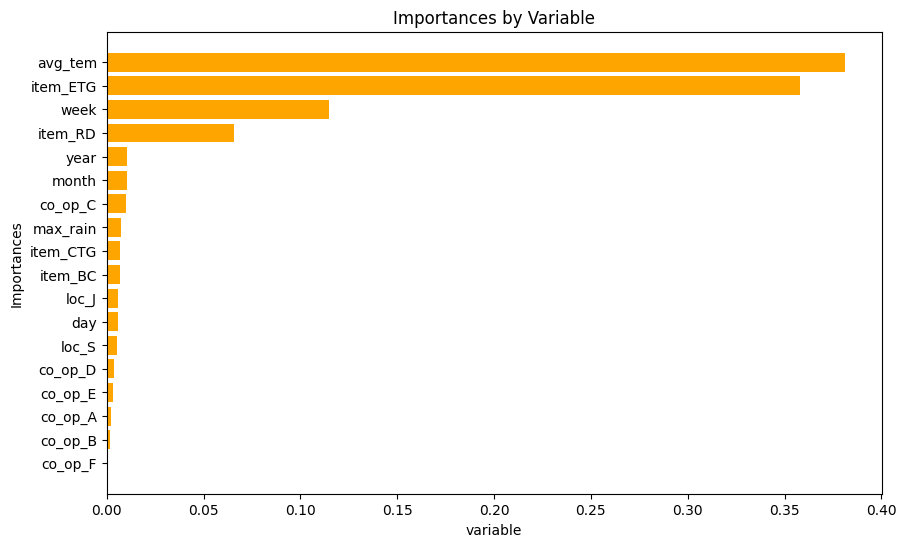

In [45]:
importances = model.feature_importances_
i_df = pd.DataFrame({
    'variable': X_train.columns,
    'Importances': importances
})


i_df = i_df.sort_values(by='Importances', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(i_df['variable'], i_df['Importances'], color='orange')
plt.xlabel('variable')
plt.ylabel('Importances')
plt.title('Importances of Variable')
plt.gca().invert_yaxis()
plt.show()

# Check 2023 Data

In [81]:
preds = model.predict(test_x)

mse = mean_squared_error(test_y, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

array([3656.26277726,  704.10048509,  725.2342777 , ..., 2725.37703997,
       4446.47086408,  463.24509862])

In [35]:
test_df.insert(7,'pred_price',preds)

pred_df=pd.concat([train_df,test_df])

pred_df=pred_df[pred_df['timestamp']>='2022-11'].reset_index(drop=True)
pred_df['price']=round(pred_df['price']/100,2)
pred_df['pred_price']=round(pred_df['pred_price']/100,2)
pred_df

,id,timestamp,supply,price,year,month,week,pred_price,day,yemon,...,item_ETG,item_RD,co_op_A,co_op_B,co_op_C,co_op_D,co_op_E,co_op_F,loc_J,loc_S
18753,BC_D_J_20230103,2023-01-03,27.36,3637.0,2023,1,1,3661.802587,1,2023-01,...,False,False,False,False,False,True,False,False,True,False
18754,RD_D_S_20230103,2023-01-03,211.20,561.0,2023,1,1,705.854734,1,2023-01,...,False,True,False,False,False,True,False,False,False,True
18755,RD_A_S_20230103,2023-01-03,278.60,588.0,2023,1,1,726.884990,1,2023-01,...,False,True,True,False,False,False,False,False,False,True
18756,BC_B_J_20230103,2023-01-03,0.80,3750.0,2023,1,1,3652.431561,1,2023-01,...,False,False,False,True,False,False,False,False,True,False
18757,BC_C_J_20230103,2023-01-03,0.80,3625.0,2023,1,1,3450.985438,1,2023-01,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19833,BC_C_J_20230303,2023-03-03,3.04,2934.0,2023,3,9,2432.721633,4,2023-03,...,False,False,False,False,True,False,False,False,True,False
19834,BC_B_J_20230303,2023-03-03,12.32,2558.0,2023,3,9,2703.030701,4,2023-03,...,False,False,False,True,False,False,False,False,True,False
19835,BC_A_J_20230303,2023-03-03,107.28,2850.0,2023,3,9,2730.629470,4,2023-03,...,False,False,True,False,False,False,False,False,True,False
19836,TG_C_J_20230303,2023-03-03,64.35,5175.0,2023,3,9,4449.390155,4,2023-03,...,True,False,False,False,True,False,False,False,True,False


## Visualization

C:\Users\USER\AppData\Local\Temp\ipykernel_37680\3370089038.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pred_df_for_plot,
C:\Users\USER\AppData\Local\Temp\ipykernel_37680\3370089038.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pred_df_for_plot,


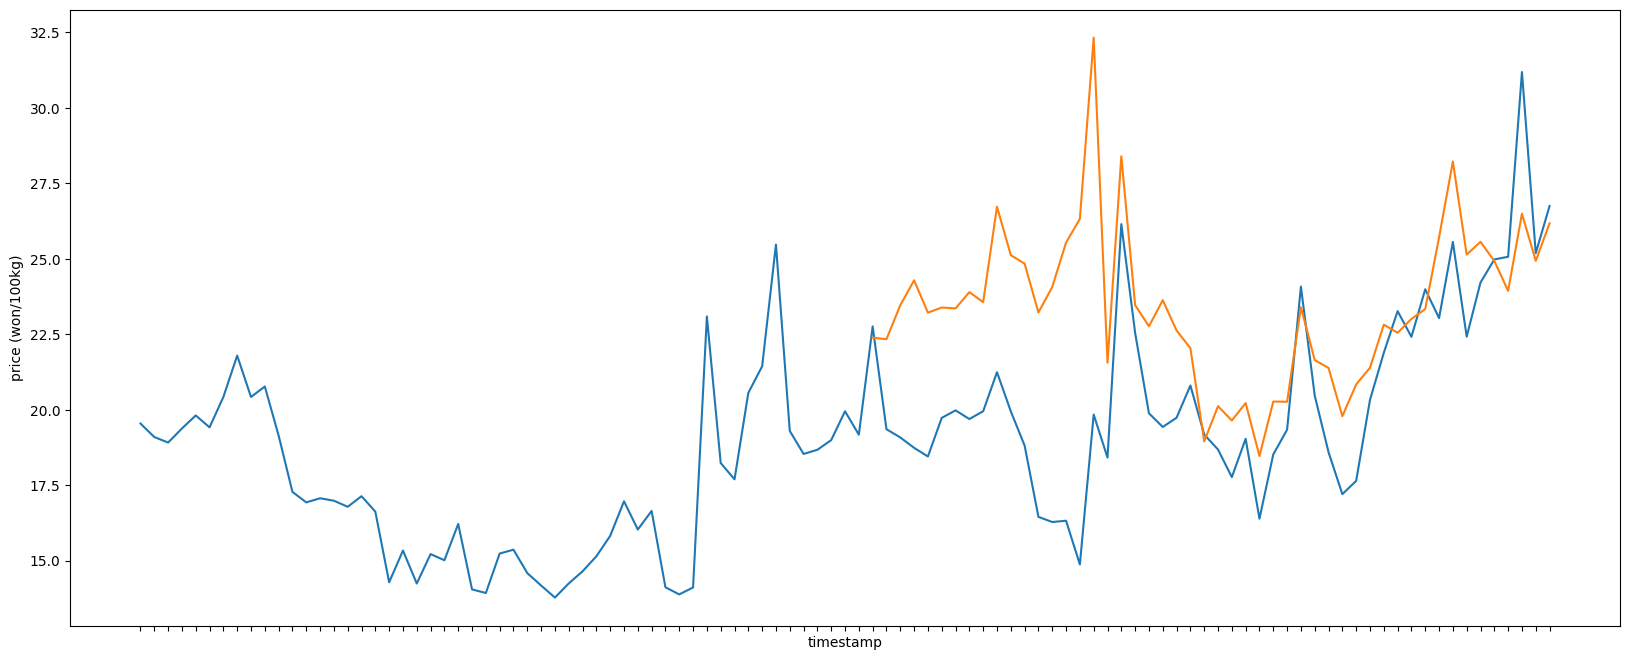

In [43]:
fig = plt.figure(figsize=(20, 8))
sns.lineplot(data=pred_df_for_plot,
             x='timestamp',
             y='price',
             ci=None)
sns.lineplot(data=pred_df_for_plot,
             x='timestamp',
             y='pred_price',
             ci=None)
plt.xticks(rotation=45)
plt.xlabel('timestamp')
plt.ylabel('price (won/100kg)')
ax = plt.gca()
ax.tick_params(labelbottom=False)
plt.show()